In [3]:
#TOOLS
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import torchvision

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## import data
*torchvision.datasetsis* a dataset im pytorch

Args:
 |      root (string): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``

 |          and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.

 |      train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
 
 |          otherwise from ``t10k-images-idx3-ubyte``.
 
 |      download (bool, optional): If True, downloads the dataset from the internet and
 
 |          puts it in root directory. If dataset is already downloaded, it is not
 
 |          downloaded again.
 
 |      transform (callable, optional): A function/transform that  takes in an PIL image
 
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 
 |      target_transform (callable, optional): A function/transform that takes in the
 
 |          target and transforms it.
 
 | root（字符串）：数据集的根目录，其中存在MNIST/raw/train-images-idx3-ubyte和MNIST/raw/t10k-images-idx3-ubyte。
 
 | train（布尔值，可选）：如果为True，则从train-images-idx3-ubyte创建数据集，
 
 | 否则从t10k-images-idx3-ubyte创建。
 
 | download（布尔值，可选）：如果为True，会从互联网下载数据集并将其放入根目录。如果数据集已经下载，则不会再次下载。
 
 | transform（可调用函数，可选）：一个接收PIL图像并返回转换后版本的函数/变换。例如，transforms.RandomCrop
 
 | target_transform（可调用函数，可选）：一个接收目标并对其进行转换的函数/变换。


In [4]:
#DATASET
train_data=torchvision.datasets.MNIST('data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
# help(torchvision.datasets.MNIST)
test_data=torchvision.datasets.MNIST('data',train=False,transform=torchvision.transforms.ToTensor(),download=True)
# help(torchvision.datasets.MNIST)

In [5]:
help(torch.utils.data.DataLoader)

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: int = 2, persistent_workers: bool = False, pin_memory_device: str = '')
 |  
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process l

In [6]:
import torch.utils
batch_size=32
train_dl=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dl=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [7]:
imgs,labels=next(iter(train_dl))
imgs.shape

torch.Size([32, 1, 28, 28])

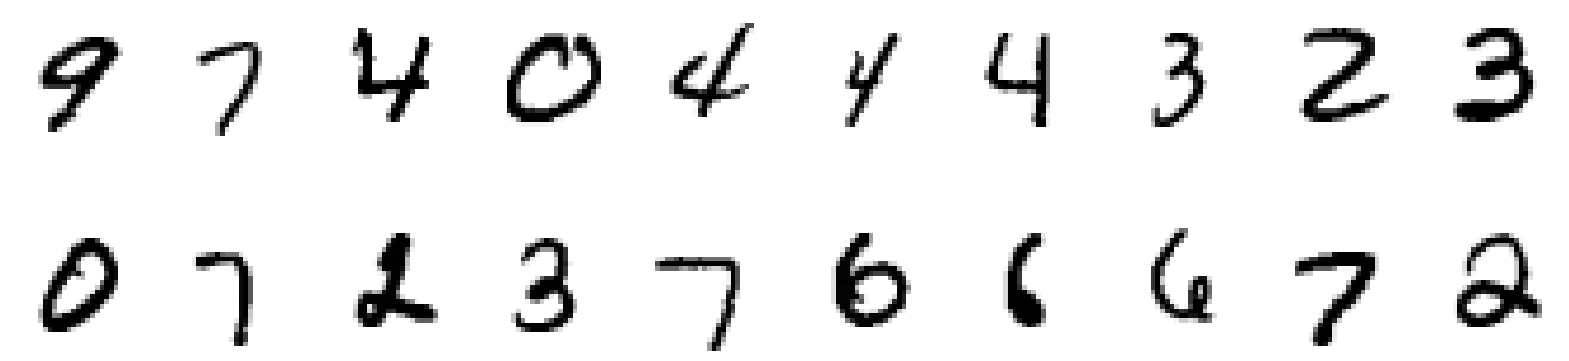

In [8]:
import numpy as np 
plt.figure(figsize=(20,5))
for i,imgs in enumerate(imgs[:20]):
    npimg=np.squeeze(imgs.numpy())
    plt.subplot(2,10,i+1)
    plt.imshow(npimg,cmap=plt.cm.binary)
    plt.axis('off')

In [7]:
import torch.nn.functional as F
num_classes=10 #kinds of img show 0-9

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3)#black_white 1,RGB 3;
        self.pool1=nn.MaxPool2d(2)# 2*2
        self.conv2=nn.Conv2d(32,64,kernel_size=3)
        self.pool2=nn.MaxPool2d(2)
        
        self.fc1=nn.Linear(1600,64)
        self.fc2=nn.Linear(64,num_classes)
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=torch.flatten(x,start_dim=1)
        
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [8]:
#model summary
import torchinfo
from torchinfo import summary
model=Model().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            102,464
├─Linear: 1-6                            650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0

In [9]:
loss_fun=nn.CrossEntropyLoss() #CrossEntropy

learn_rate=1e-2 # alpha
opt=torch.optim.SGD(model.parameters(),lr=learn_rate)# method of gradient descent

In [10]:
# train fun
def train(dataloader,model,loss_fun,optimizer):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    
    train_loss,train_acc=0,0
    
    for X,y in dataloader:
        X,y=X.to(device),y.to(device)
        
        pred =model(X)
        loss=loss_fun(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc+=(pred.argmax(1)==y).type(torch.float).sum().item()
        train_loss+=loss.item()
    
    train_acc/=size
    train_loss/=num_batches
    
    return train_acc,train_loss
        

In [11]:
# test fun
def test(dataloader,model,loss_fun):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    
    test_loss,test_acc=0,0
    with torch.no_grad():
        for imgs,target in dataloader:
            imgs,target =imgs.to(device),target.to(device)
            
            target_pre=model(imgs)
            loss=loss_fun(target_pre,target)
            
            
            test_loss+=loss.item()
            test_acc+=(target_pre.argmax(1)==target).type(torch.float).sum().item()
            # test_loss+=loss.item()
            
        test_acc/=size
        test_loss/=num_batches
        
        return test_acc,test_loss
        

In [12]:
# train process
epochs=5
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(epochs):
    model.train()
    epoch_train_acc,epoch_train_loss=train(train_dl,model,loss_fun,opt)
    
    model.eval()
    epoch_test_acc,epoch_test_loss=test(test_dl,model,loss_fun)
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template=('Epoch:{:2d},Train_acc:{:.1f}%,Train_loss:{:.3f},Test_acc:{:.1f}%,Test_loss:{:.3f}')
    print(template.format(epoch+1,epoch_train_acc*100,epoch_train_loss,epoch_test_acc*100,epoch_test_loss))
print("Done")
    


Epoch: 1,Train_acc:78.8%,Train_loss:0.743,Test_acc:92.3%,Test_loss:0.263
Epoch: 2,Train_acc:94.2%,Train_loss:0.192,Test_acc:96.2%,Test_loss:0.127
Epoch: 3,Train_acc:96.3%,Train_loss:0.122,Test_acc:97.1%,Test_loss:0.096
Epoch: 4,Train_acc:97.2%,Train_loss:0.093,Test_acc:97.7%,Test_loss:0.070
Epoch: 5,Train_acc:97.6%,Train_loss:0.076,Test_acc:97.8%,Test_loss:0.068
Done


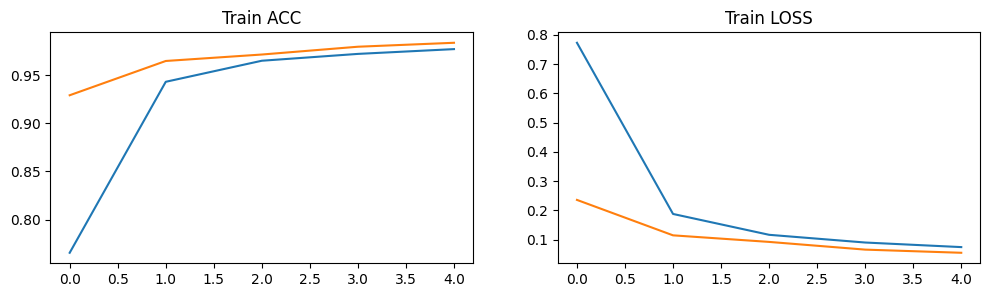

In [101]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.plot(range(epochs),train_acc,label='Train_acc')
plt.plot(range(epochs),test_acc,label='Test_acc')
plt.title('Train ACC')

plt.subplot(1,2,2)
plt.plot(range(epochs),train_loss,label='Train_loss')
plt.plot(range(epochs),test_loss,label='Test_loss')
plt.title('Train LOSS')

plt.show()